[![mnist.gif](https://i.postimg.cc/W1cwV9JR/mnist.gif)](https://postimg.cc/vcXVLtzX)

### Table of Contents

* [Imports](#Imports)
* [Read data](#Read_data)
* [Data preparation](#Data_preparation)
* [Data loader](#Data_loader)
* [Model training](#Model_training)
* [Results](#Results)
* [Demo](#Demo)
* [Save model](#Save_model)

# **Imports** <a class="anchor" id="Imports"></a>

In [1]:
%%capture
!pip install --user torch==1.9.0 torchvision==0.10.0

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # for progress bar
from PIL import Image # for create images based on array

from fastai.vision.all import *
from fastai.metrics import *
from fastai.imports import *

# ignore warnings
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

# **Read data** <a class="anchor" id="Read_data"></a>

In [3]:
# we need this to run everything on GPU if it's available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Each image is 28x28
# data has 785 columns. The first column is label. The rest of the columns contain the pixel-values of the associated image
INPUT_PATH = Path(".")

train_df = pd.read_csv(INPUT_PATH/"train.csv")
test_df = pd.read_csv(INPUT_PATH/"test.csv")
train_df.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Data preparation** <a class="anchor" id="Data_preparation"></a>

In [5]:
# fastai dataloaders need images so we need to create images with appropriate folders from dataframe
# create empty directories for digit images

TRAINING_DATA_PATH = Path('./train')
TESTING_DATA_PATH = Path('./test')
for path in [TRAINING_DATA_PATH, TESTING_DATA_PATH]:
    for i in range(10):
        p = path / str(i)
        p.mkdir(parents=True, exist_ok=True)

In [6]:
def save_img(filepath, img_array):
    img = img_array.reshape(28,28)
    img = img.astype(np.uint8())
    img = Image.fromarray(img)
    img.save(filepath)
    
# save train images
for i, data in tqdm(train_df.iterrows()):
    label, data = data[0], data[1:]
    img_path = TRAINING_DATA_PATH/str(label)/f"{i}.png"
    save_img(img_path, data.values)
    
# save test images    
for i, data in tqdm(test_df.iterrows()):
    img_path = TESTING_DATA_PATH/str(label)/f"{i}.png"
    save_img(img_path, data.values)

42000it [00:11, 3814.01it/s]
28000it [00:05, 4774.19it/s]


# **Data loader** <a class="anchor" id="Data_loader"></a>

In [7]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=parent_label,
                   batch_tfms=aug_transforms(do_flip=False, mult=2))

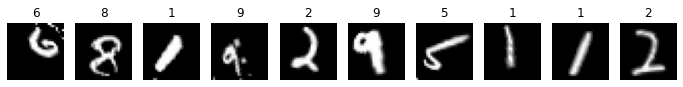

In [8]:
dls = dblock.dataloaders("train", batch_size=64, num_workers=2, device=device)
dls.show_batch(max_n=10, nrows=1, figsize=(12,6))

# **Model training** <a class="anchor" id="Model_training"></a>

SuggestedLRs(valley=0.00363078061491251)

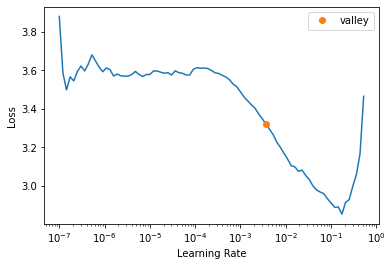

In [9]:
learner = cnn_learner(dls, resnet34, metrics=accuracy)
learner.lr_find()

In [10]:
learner.fine_tune(30, base_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.910294,0.414801,0.868095,01:53


epoch,train_loss,valid_loss,accuracy,time
0,0.230164,0.080233,0.976190,04:25
1,0.188627,0.065893,0.980357,05:08
2,0.153552,0.060336,0.981191,04:27
3,0.121823,0.058589,0.982381,04:13
4,0.127028,0.057834,0.982619,03:57
5,0.103520,0.040299,0.988690,04:08
6,0.104553,0.050251,0.986905,03:45
7,0.103910,0.054105,0.983571,03:33
8,0.087559,0.045370,0.987500,04:00
9,0.081997,0.034505,0.987857,03:59


# **Results** <a class="anchor" id="Results"></a>

[('9', '4', 5)]

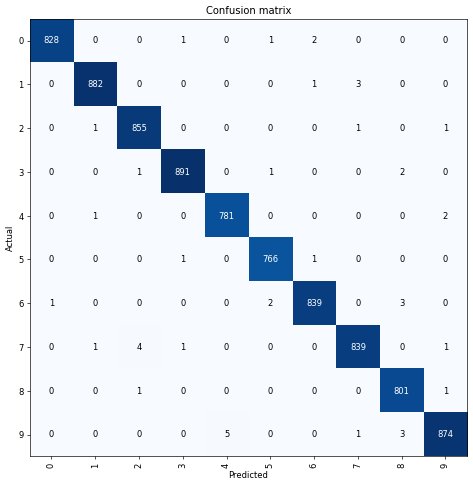

In [11]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)
interp.most_confused(min_val=5)

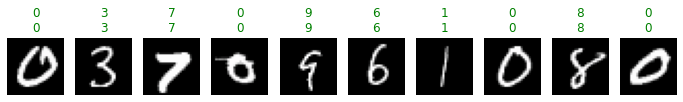

In [12]:
learner.show_results(max_n=10, nrows=1, figsize=(12,6))

# **Demo** <a class="anchor" id="Demo"></a>

In [ ]:
%%capture

!pip install gradio
import gradio as gr

In [ ]:
labels = learner.dls.vocab

def classify(img):
    pred, pred_idx, probs = learner.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}


interface = gr.Interface(fn=classify, inputs="sketchpad", outputs=gr.outputs.Label(num_top_classes=5), live=True)
interface.launch(debug=True, share=True)

# **Save model** <a class="anchor" id="Save_model"></a>

In [19]:
learner.export()

In [20]:
# clean temporary folder
!rm -r "./train"
!rm -r "./test"